STEP - 1

Load and Split the Dataset(6 Classes)

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split


In [17]:
# Path to your dataset
dataset_dir = r"C:\Users\JAI\Downloads\archive\Garbage classification\Garbage classification"  # Change this to your dataset folder path
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [18]:
# Create folders for train, val, test
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(split, cls), exist_ok=True)


In [23]:
# Split each class into train/val/test
for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    images = os.listdir(cls_path)
    
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

# Copy images to respective folders

    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join('train', cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join('val', cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join('test', cls, img))

print("Dataset split completed!")    
    

Dataset split completed!


STEP- 2 & 3

Preprocessing,Augmentation & EDA

In [27]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os


C:\Users\JAI\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\JAI\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\JAI\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/res

In [28]:
# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [29]:
# Data generators with augmentation for training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,          # Normalize pixels
    rotation_range=15,       # Random rotation
    width_shift_range=0.1,   # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    zoom_range=0.2,          # Zoom
    horizontal_flip=True,    # Horizontal flip
    validation_split=0.15    # Split 15% for validation
)

In [30]:
# Train generator
train_generator = train_datagen.flow_from_directory(
    'train',                  # Path to training folder
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    'val',                    # Path to validation folder
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Test generator (only rescale)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1766 images belonging to 6 classes.
Found 378 images belonging to 6 classes.
Found 383 images belonging to 6 classes.


In [ ]:
# EDA: Visualize class distribution

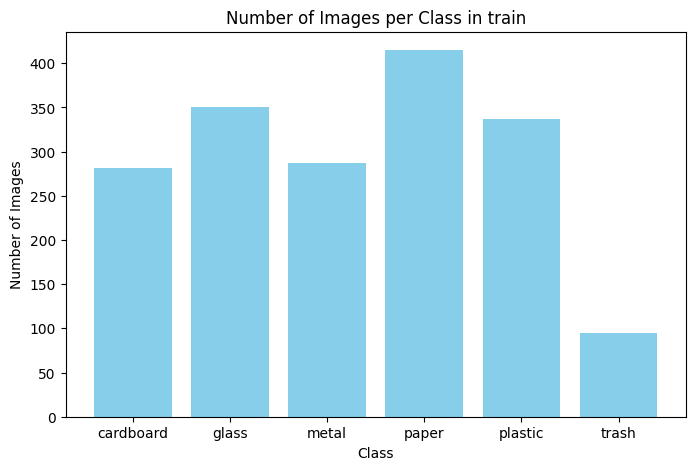

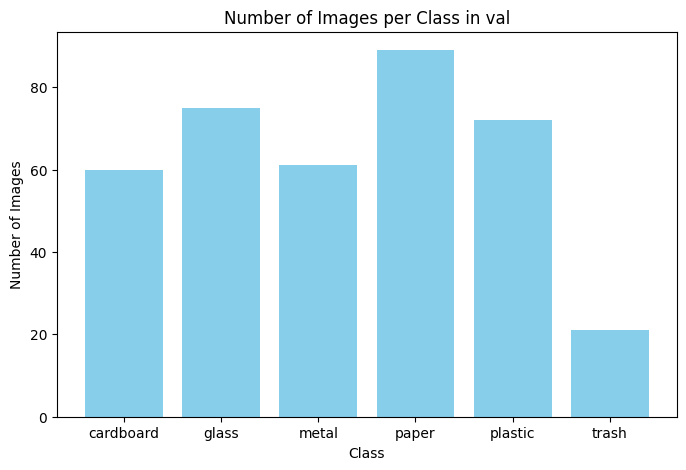

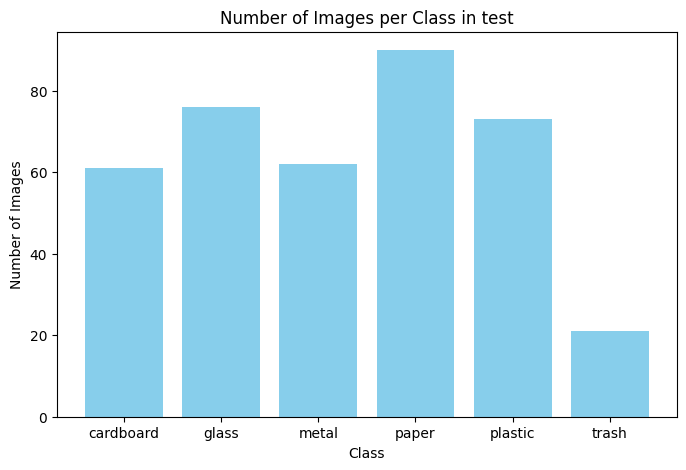

In [31]:
def plot_class_distribution(folder_path):
    counts = {}
    for cls in classes:
        cls_folder = os.path.join(folder_path, cls)
        counts[cls] = len(os.listdir(cls_folder))
    plt.figure(figsize=(8,5))
    plt.bar(counts.keys(), counts.values(), color='skyblue')
    plt.title(f"Number of Images per Class in {folder_path}")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.show()

plot_class_distribution('train')
plot_class_distribution('val')
plot_class_distribution('test')


In [ ]:
# EDA: Show sample images per class

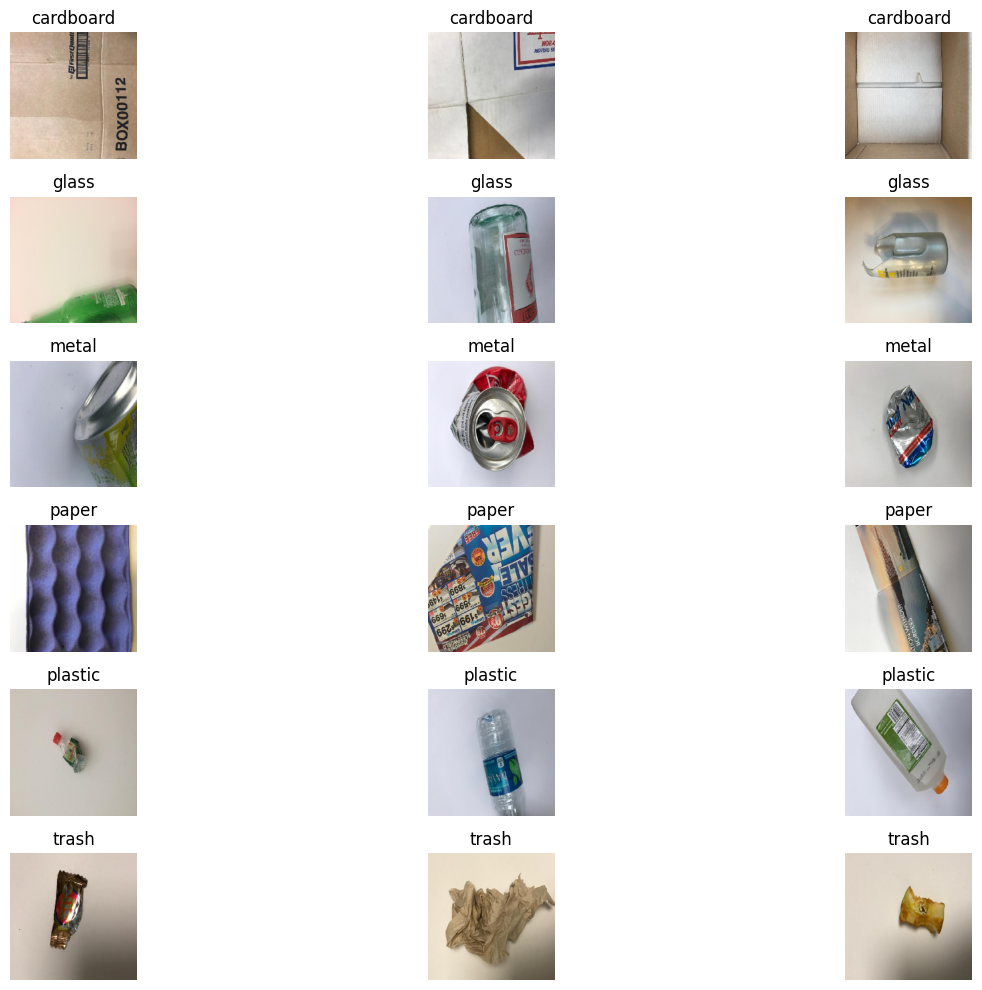

In [32]:
def show_sample_images(folder_path, num_images=3):
    plt.figure(figsize=(15,10))
    for idx, cls in enumerate(classes):
        cls_folder = os.path.join(folder_path, cls)
        images = os.listdir(cls_folder)[:num_images]
        for i, img_name in enumerate(images):
            img_path = os.path.join(cls_folder, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
            img = tf.keras.preprocessing.image.img_to_array(img)/255.0
            plt.subplot(len(classes), num_images, idx*num_images + i + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images('train')

STEP - 4

Model Development Code(MobileNetV2, 6 Classes)

In [33]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 6


In [34]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15
)

train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 1503 images belonging to 6 classes.
Found 263 images belonging to 6 classes.


In [39]:
# Load MobileNetV2 base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base layers

# Add custom classifier layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Save trained model
model.save("waste_classifier.h5")
print("✅ Model saved as waste_classifier.h5")


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.6786 - loss: 0.8713 - val_accuracy: 0.7224 - val_loss: 0.6624
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8144 - loss: 0.5010 - val_accuracy: 0.7148 - val_loss: 0.7815
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8410 - loss: 0.4334 - val_accuracy: 0.7148 - val_loss: 0.7541
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8829 - loss: 0.3414 - val_accuracy: 0.7529 - val_loss: 0.6162
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9115 - loss: 0.2667 - val_accuracy: 0.7338 - val_loss: 0.6267
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9248 - loss: 0.2205 - val_accuracy: 0.7871 - val_loss: 0.6076
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9235 - loss: 0.2047 - val_accuracy: 0.7529 - val_loss: 0.7188
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9434 - loss: 0.1752 - val_accuracy: 0.7567 - val_loss:

✅ Model saved as waste_classifier.h5


STEP - 5

Model Evaluation

1. Evaluate Accuracy on Test Set

In [36]:
# Assuming test images are in 'test' folder
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")


Found 383 images belonging to 6 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7859 - loss: 0.6967
Test Accuracy: 78.59%


2. Confusion Matrix & Classification Report

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict labels for test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Classification report
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=target_names)
print("Classification Report:\n", report)

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 887ms/step
Confusion Matrix:
 [[48  0  1 10  1  1]
 [ 0 49 13  3  9  2]
 [ 0  1 58  2  1  0]
 [ 0  0  0 87  1  2]
 [ 1  6  7  9 48  2]
 [ 0  1  3  5  1 11]]
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.98      0.79      0.87        61
       glass       0.86      0.64      0.74        76
       metal       0.71      0.94      0.81        62
       paper       0.75      0.97      0.84        90
     plastic       0.79      0.66      0.72        73
       trash       0.61      0.52      0.56        21

    accuracy                           0.79       383
   macro avg       0.78      0.75      0.76       383
weighted avg       0.80      0.79      0.78       383



3. Visualize Confusion Matrix

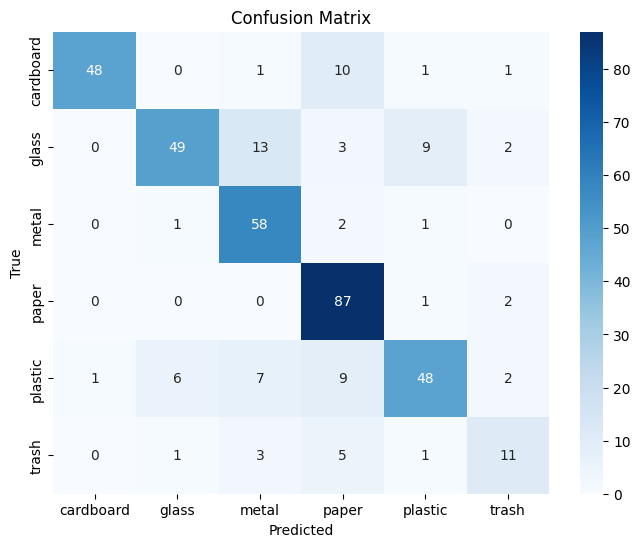

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

STEP - 6

Streamlit App Code

In [ ]:
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load trained model
model = tf.keras.models.load_model("waste_classifier.h5")

# Class names (must match training order)
class_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Sidebar
st.sidebar.title("♻️ RecycleVision")
st.sidebar.info(
    """
    📌 Upload a garbage image  
    📌 Our AI model will classify it  
    📌 Categories: Cardboard, Glass, Metal, Paper, Plastic, Trash
    """
)

# Main title
st.title("♻️ RecycleVision - Garbage Classification App")
st.markdown("### Upload an image and let AI predict the type of waste 🗑️")

# File uploader
uploaded_file = st.file_uploader("📤 Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Display uploaded image
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="🖼️ Uploaded Image", use_column_width=True)

    # Preprocess image
    img = image.resize((224, 224))   # Resize to match model input
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediction
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    # Show result
    st.success(f"✅ Prediction: **{predicted_class}**")
    st.info(f"📊 Confidence: **{confidence:.2f}%**")

    # Bar chart of probabilities
    fig, ax = plt.subplots()
    ax.bar(class_names, predictions[0], color="skyblue")
    ax.set_ylabel("Probability")
    ax.set_xlabel("Class")
    ax.set_title("Prediction Probabilities")
    plt.xticks(rotation=30)

    st.pyplot(fig)

# Footer
st.markdown("---")
st.markdown("🚀 Built with ❤️ using **Streamlit + TensorFlow**")

